## Aprendizaje automático relacional con extraacción manual de características

In [ ]:
X = np.transpose(pd.DataFrame([degrees.values(),clustering.values(), closeness.values(),
                   pagerank.values(), betweenness.values()]))
X.columns = ["degree", "clustering", "closeness", "pagerank", "betweenness"]
y = target["ml_target"]

print(X.head(5))
print(y.head(5))

     degree  clustering  closeness  pagerank   betweenness
0  0.000027    0.000000   0.275027  0.000047  0.000000e+00
1  0.000212    0.178571   0.294980  0.000952  1.149915e-06
2  0.000027    0.000000   0.261866  0.000036  0.000000e+00
3  0.000133    0.000000   0.278740  0.000105  5.317143e-05
4  0.000053    0.000000   0.243103  0.000009  6.135293e-09
0    0
1    0
2    1
3    0
4    1
Name: ml_target, dtype: int64


In [ ]:
X.to_csv("X.csv")

Partición entrenamiento - test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

#### DT

In [ ]:
clf = tree.DecisionTreeClassifier(max_depth=3)
clf.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=3)

[Text(0.5, 0.875, 'x[3] <= 0.0\ngini = 0.384\nsamples = 25259\nvalue = [18724.0, 6535.0]'),
 Text(0.25, 0.625, 'x[2] <= 0.281\ngini = 0.481\nsamples = 9236\nvalue = [5520, 3716]'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'x[4] <= 0.0\ngini = 0.496\nsamples = 5587\nvalue = [3049.0, 2538.0]'),
 Text(0.0625, 0.125, 'gini = 0.483\nsamples = 3849\nvalue = [2282, 1567]'),
 Text(0.1875, 0.125, 'gini = 0.493\nsamples = 1738\nvalue = [767, 971]'),
 Text(0.375, 0.375, 'x[4] <= 0.0\ngini = 0.437\nsamples = 3649\nvalue = [2471, 1178]'),
 Text(0.3125, 0.125, 'gini = 0.357\nsamples = 1937\nvalue = [1487, 450]'),
 Text(0.4375, 0.125, 'gini = 0.489\nsamples = 1712\nvalue = [984, 728]'),
 Text(0.75, 0.625, 'x[3] <= 0.004\ngini = 0.29\nsamples = 16023\nvalue = [13204, 2819]'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'x[2] <= 0.343\ngini = 0.342\nsamples = 10777\nvalue = [8419, 2358]'),
 Text(0.5625, 0.125, 'gini = 0.29\nsamples = 7410\nvalue = [6106, 1304]'),
 Text(0.6875, 0.125, 'g

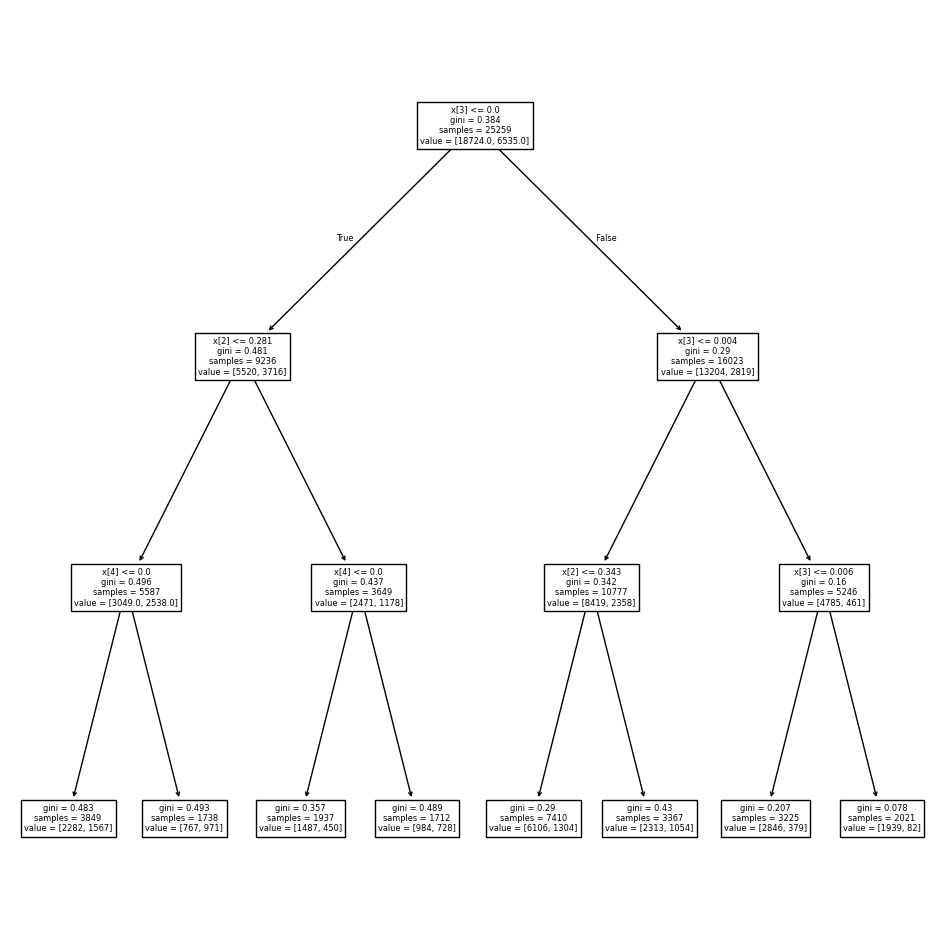

In [ ]:
plt.figure(figsize=(12,12))
tree.plot_tree(clf)

Evaluación

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix


y_pred = clf.predict(X_test)

print(accuracy_score(y_true= y_test,y_pred=y_pred))

print(confusion_matrix(y_true= y_test,y_pred=y_pred))

0.7537979262117193
[[8888  349]
 [2714  490]]
